# Modeling TCLab

Alex Dowling, University of Notre Dame

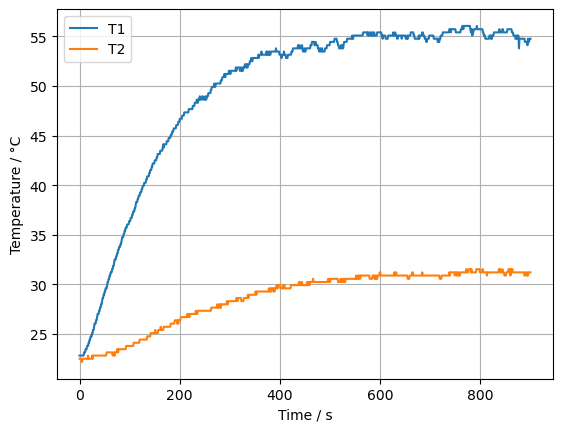

In [76]:
from FoKL import FoKLRoutines
import numpy as np
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt

# filename = 'tclab_sine_test.csv'
filename = 'tclab_step_test.csv'

data = pd.read_csv(filename)
data.plot(x='Time', y=['T1', 'T2'], grid=True, xlabel='Time / s', ylabel='Temperature / °C')
plt.show()

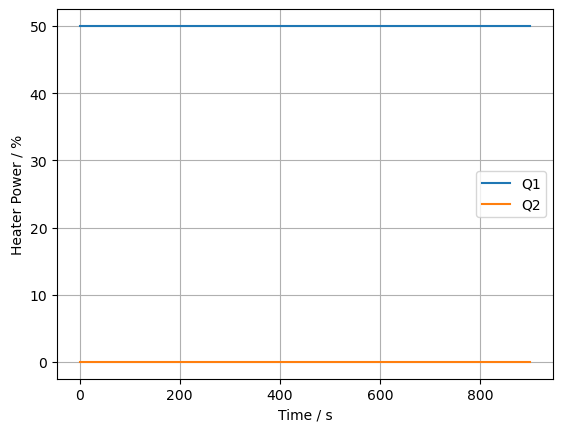

In [77]:
data.plot(x='Time', y=['Q1', 'Q2'], grid=True, xlabel='Time / s', ylabel='Heater Power / %')
plt.show()

## Linear System Model

In [78]:
# define the time vector
t = data['Time'].values
print("length of time vector: ", len(t))

# calculate Tamb
Tamb = data['T1'].values[0]

u_function = lambda t: np.interp(t, data['Time'].values, data['Q1'].values)

def single_heater_model(t, T, u_function, theta):
    dTdt = (theta[0]*(Tamb-T) + theta[1]*u_function(t))*60
    return dTdt

length of time vector:  901


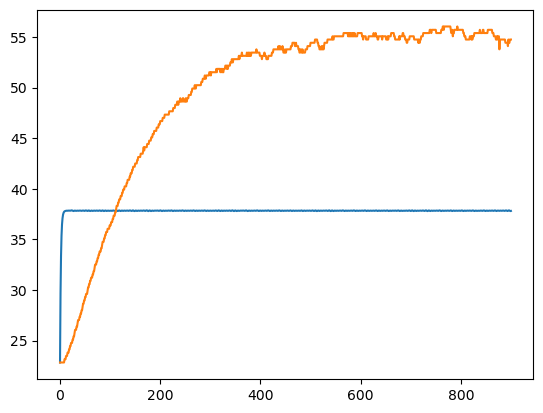

In [79]:
from scipy.integrate import solve_ivp


theta0 = [0.01, 0.003]
sln = solve_ivp(single_heater_model, t_span=(t[0], t[-1]), y0=[Tamb], t_eval=t, args=(u_function, theta0))

plt.plot(t, sln.y[0], label='Model')
plt.plot(t, data['T1'], label='Data')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.5252e+04                                    5.34e+07    
       1              2         3.1765e+04      6.35e+04       2.32e-03       1.19e+06    
       2              3         3.1726e+04      3.90e+01       1.34e-04       1.01e+05    
       3              4         3.1719e+04      7.73e+00       9.19e-05       1.04e+05    
       4              5         3.1710e+04      8.75e+00       9.96e-05       1.01e+05    
       5              6         3.1701e+04      8.54e+00       9.67e-05       1.04e+05    
       6              7         3.1694e+04      7.55e+00       9.73e-05       1.14e+05    
       7              8         3.1685e+04      8.87e+00       9.45e-05       1.11e+05    
       8              9         3.1675e+04      9.55e+00       9.34e-05       1.06e+05    
       9             10         3.1666e+04      9.59e+00       1.03e-04       1.23e+05    

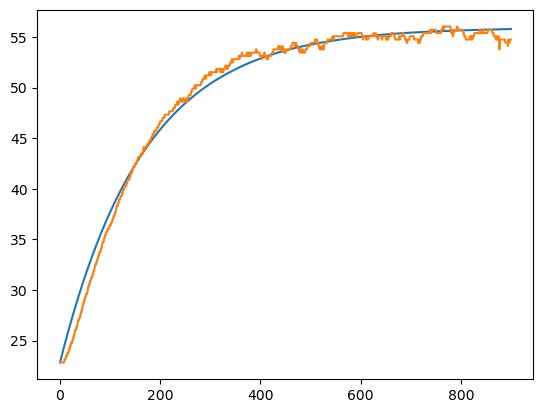

In [80]:
def residual(theta):
    sln = solve_ivp(single_heater_model, t_span=(t[0], t[-1]), y0=[Tamb], t_eval=t, args=(u_function, theta))
    return sln.y[0] - data['T1'].values

from scipy.optimize import least_squares
regress_results = least_squares(residual, theta0, verbose=2)

print(regress_results.x)

sln = solve_ivp(single_heater_model, t_span=(t[0], t[-1]), y0=[Tamb], t_eval=t, args=(u_function, regress_results.x))

plt.plot(t, sln.y[0], label='Model')
plt.plot(t, data['T1'], label='Data')

## GP Discrepency Model

We want to train the following mathematical model:

$$
\frac{dT_1}{dt} = f(T_1, Q_1)
$$

where $f(\cdot, \cdot)$ is the GP.

length of time vector:  901
length of derivative vector:  901
length of T1_smooth vector:  901
length of u1 vector:  901


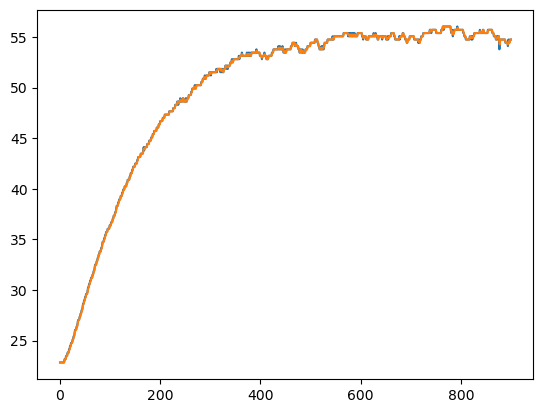

In [81]:
# TODO: look into smoothing the data, or fit smoothing GP to the data
# good chance the derivative is really noisy
# look for "smooth_diff"

# apply rolling mean to smooth the data
window = 2
T1_smooth = data['T1'].rolling(window=window).mean()

# copy the first window values to the beginning of the smoothed data
T1_smooth[0:window] = data['T1'].values[0:window]

# define the time vector
t = data['Time'].values
print("length of time vector: ", len(t))

# calculate the derivative of the smoothed data
dT1dt = np.gradient(T1_smooth, t)
print("length of derivative vector: ", len(dT1dt))

# calculate Tamb
Tamb = T1_smooth[0]

print("length of T1_smooth vector: ", len(T1_smooth))


u1 = data['Q1'].values
print("length of u1 vector: ", len(u1))


plt.plot(t, data['T1'], label='T1 (raw)')
plt.plot(t, T1_smooth, label='T1 (smooth)')
plt.show()


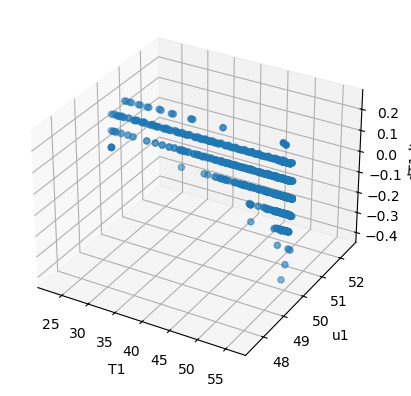

In [83]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(T1_smooth, u1, dT1dt)
ax.set_xlabel('T1')
ax.set_ylabel('u1')
ax.set_zlabel('dT1dt')
plt.show()

## Train Model

In [84]:
f = FoKLRoutines.FoKL(kernel=1, UserWarnings=True)
print("\nTraining FoKL model...")
betas, mtx, evs = f.fit([T1_smooth - Tamb, u1], dT1dt, clean=True)
print("Done!")
f.save('attempt1.fokl')


Training FoKL model...


/Users/adowling/opt/anaconda3/envs/FoKL/lib/python3.10/site-packages/FoKL/FoKLRoutines.py:292: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "
/Users/adowling/opt/anaconda3/envs/FoKL/lib/python3.10/site-packages/FoKL/FoKLRoutines.py:302: UserWarning: 'inputs' contains a column of constants which will not improve the model's fit.
  warnings.warn("'inputs' contains a column of constants which will not improve the model's fit."


[1, -3672.464294991217]
[2, -3672.464294991217]
[2, -3702.896237854559]
[3, -3702.896237854559]
[3, -3709.9635475418327]
[4, -3709.9635475418327]
[4, -3703.158100452212]
[4, -3701.5219803472046]
Done!


'attempt1.fokl'

In [ ]:
# Plot to visualize dataset and model:
# f.coverage3(plot=True, xlabel='t', xaxis=t, ylabel='y')

In [85]:
dT1dt_pred = f.evaluate([T1_smooth - Tamb, u1], betas, mtx)

/Users/adowling/opt/anaconda3/envs/FoKL/lib/python3.10/site-packages/FoKL/FoKLRoutines.py:742: UserWarning: Provided inputs were converted to numpy array as float64. To change this datatype, call 'clean' first.
  warnings.warn(f"Provided inputs were converted to numpy array as float64. To change this datatype, "
/Users/adowling/opt/anaconda3/envs/FoKL/lib/python3.10/site-packages/FoKL/FoKLRoutines.py:750: UserWarning: Provided inputs were not normalized, so overriding 'clean' to True.
  warnings.warn("Provided inputs were not normalized, so overriding 'clean' to True.")


In [86]:
dt = np.gradient(t)

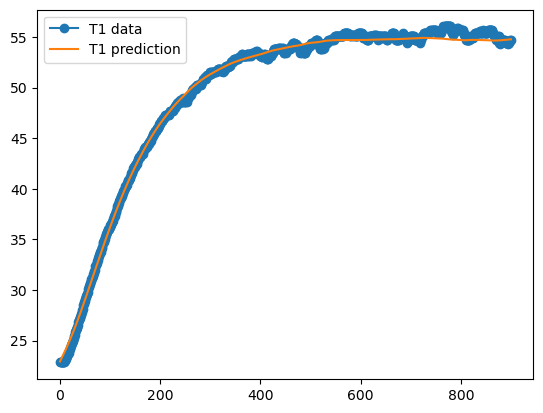

In [87]:
# This is a very simple integration of the derivative to get the prediction
T1_pred = np.cumsum(dT1dt_pred*dt)

plt.plot(t, T1_smooth, label='T1 data', marker='o')
plt.plot(t, T1_pred + Tamb, label='T1 prediction', linestyle='-')
plt.legend()
plt.show()